<a href="https://colab.research.google.com/github/smraytech/test/blob/main/Samuel_Mukisa_CNN_ViTs_Recall_Precision_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data

Loading the necessary libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras import layers, models
import seaborn as sns
plt.show()
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical

Carrying out Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
   layers.RandomFlip("horizontal_and_vertical"),
   layers.RandomRotation(0.3),
   layers.RandomZoom(0.3),
   layers.RandomContrast(0.3),
   layers.RandomBrightness(0.2)
])

Path to to the dataset and Load the training dataset


In [ ]:
training_path = '/content/drive/MyDrive/Dataset_braintumor/brain_tumor/Training'
training_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    training_path,
    batch_size=32,
    image_size=(128,128)
)

Found 5712 files belonging to 4 classes.


Path to the dataset and Load testing dataset

In [ ]:
testing_path = '/content/drive/MyDrive/Dataset_braintumor/brain_tumor/Testing'
testing_data_set = tf.keras.preprocessing.image_dataset_from_directory(
    testing_path,
    batch_size=32,
    image_size=(128,128)
)

Found 1311 files belonging to 4 classes.


Displaying Sample images from the training dataset affter normalisation

Found 5712 files belonging to 4 classes.


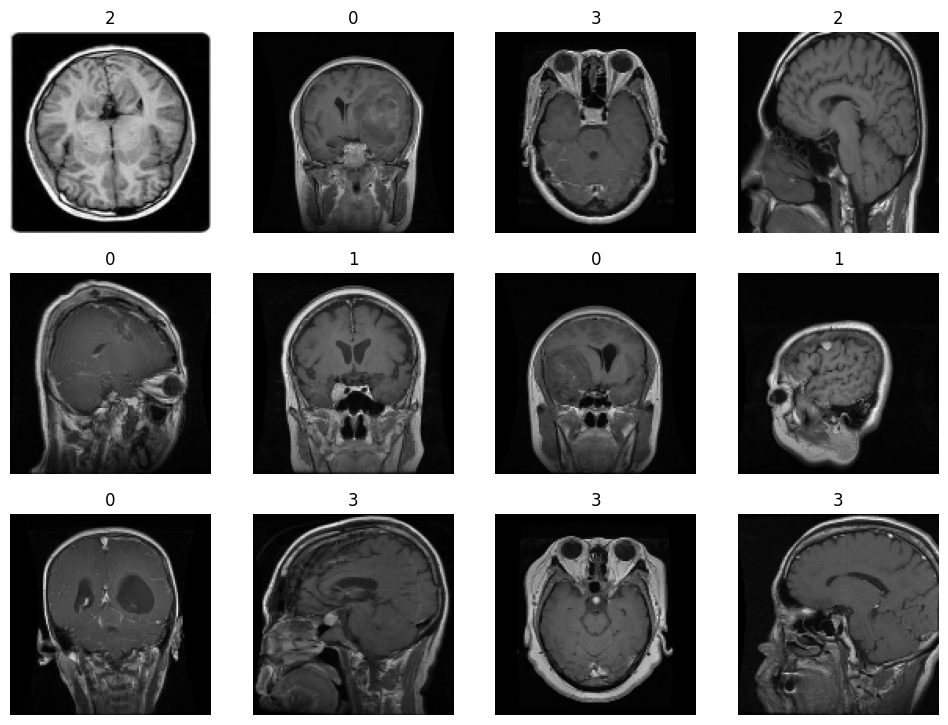

In [ ]:
training_path = '/content/drive/MyDrive/Dataset_braintumor/brain_tumor/Training'
training_dataset = tf.keras.preprocessing.image_dataset_from_directory(
 training_path,
 batch_size=32,
 image_size=(128,128)
)
def normalize(images, labels):
  return (images / 255.0, labels)

def display_sample_images(dataset):
  plt.figure(figsize=(12,12))
  for images, labels in dataset.take(1):
    for i in range(12):
      ax = plt.subplot(4, 4, i + 1)
      image = images[i].numpy()
      image = (image - np.min(image)) / (np.max(image) - np.min(image))     # Normalization
      plt.imshow(image)
      plt.title(labels[i].numpy())
      plt.axis("off")
  plt.show()
display_sample_images(training_dataset)

2.2.2 Displaying the First 12 Images
The following code snippet shows how to load the images, normalize them, and display the first 12 images in the dataset.

3. Model Architecture

3.1 Convolutional Neural Network (CNN)


CNNs have proven effective in image classification tasks, leveraging convolutional layers to automatically extract features from input images.

3.1.1 Key Components

*Convolutional Layers: Utilize learnable filters to create feature maps that highlight essential features of the input.
*Pooling Layers: Reduce spatial dimensions, typically employing MaxPooling.
*Activation Functions: Non-linear functions (e.g., ReLU) introduce non-linearity to the model.




3.2 Vision Transformer (ViT)

ViTs leverage self-attention mechanisms, transforming images into patches to capture relationships across various sections.

3.2.1 Key Components

*Patch Embedding: Images are divided into patches, which are flattened and projected.
*Self-Attention Mechanism: Allows the model to weigh the importance of different patches based on contextual relationships.
*Feed-Forward Network: Processes outputs from the self-attention mechanism.

3.3 Hybrid Model Architecture
The hybrid model combines the feature extraction of CNNs with the global context understanding of ViTs. The output from the CNN serves as input for the ViT, creating a robust classification architecture.

3.3.1 Hybrid Model Implementation

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model


In [ ]:
def create_cnn_model(input_shape):
  model = tf.keras.Sequential([
      layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128,128,3)),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(64, (3, 3), activation='relu'),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(128, (3, 3), activation= 'relu'),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Flatten(),
      layers.Dense(128, activation='relu')
  ])
  return model


def patch_embedding_layer(patch_size, embed_dim):
  def embed_patches(x):
    patches = tf.image.extract_patches(
        images=x,
        sizes=[1, patch_size[0], patch_size[1], 1],
        strides= [1, patch_size[0], patch_size[1], 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )




def create_vit_model(num_patches, embed_dim):
  inputs = layers.Input(shape=(num_patches, embed_dim))

  x = layers.Dense(embed_dim, activation='relu')(inputs)
  x = layers.LayerNormalization(epsilon=1e-6)(x)


  x = layers.GlobalAveragePooling1D()(x)
  x = layers.Dense(4, activation='softmax')(x)
  vit_model = tf.keras.Model(inputs=inputs, outputs=x)
  return vit_model



def create_hybrid_model(input_shape):

     cnn_model = create_cnn_model(input_shape)

     cnn_input = layers.Input(shape=input_shape)

     cnn_output = cnn_model(cnn_input)


     num_patches = 16
     embed_dim = 8

     cnn_output_reshaped = layers.Reshape((num_patches, embed_dim))(cnn_output)


     vit_model = create_vit_model(num_patches, embed_dim)

     vit_output = vit_model(cnn_output_reshaped)

     hybrid_model = Model(inputs=cnn_input, outputs=vit_output)
     return hybrid_model


hybrid_model = create_hybrid_model((128, 128, 3))
hybrid_model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy']
                    )
hybrid_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 128)                 │       3,304,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 16, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_4 (Functional)            │ (None, 4)                   │             124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,764 (12.61 MB)

 Trainable params: 3,304,764 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

4. Model Training and Evaluation

4.1 Training the Hybrid Model
Training involves feeding the augmented training dataset and monitoring its performance on a validation set.

4.1.1 Training Implementation

In [ ]:
hybrid_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

The hybrid_model running 50 Epochs such that it can learn all the patterns including those that are complex

In [ ]:
history = hybrid_model.fit(
    training_dataset,
    validation_data=testing_data_set,
    epochs=50
)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 737s 4s/step - accuracy: 0.5542 - loss: 1.0808 - val_accuracy: 0.6766 - val_loss: 0.8439
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.7895 - loss: 0.6565 - val_accuracy: 0.8040 - val_loss: 0.5316
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.8630 - loss: 0.4163 - val_accuracy: 0.8551 - val_loss: 0.3974
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.9238 - loss: 0.2529 - val_accuracy: 0.9123 - val_loss: 0.2569
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.9523 - loss: 0.1573 - val_accuracy: 0.9314 - val_loss: 0.1963
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.9732 - loss: 0.1082 - val_accuracy: 0.9291 - val_loss: 0.1935
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9778 - loss: 0.0791 - val_accuracy: 0.9527 - val_loss: 0.1535
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9930 - loss: 0.0385 - val_accu

4.2 Evaluation Metrics

The model's performance is evaluated using recall, precision, F1-score and accuracy.

4.2.1 Model Performance Metrics Calculation

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
                 precision    recall  f1-score   support

         Glioma       1.00      1.00      1.00         9
     Meningioma       1.00      1.00      1.00         7
Pituitary Tumor       1.00      1.00      1.00        11
       No Tumor       1.00      1.00      1.00         5

       accuracy                           1.00        32
      macro avg       1.00      1.00      1.00        32
   weighted avg       1.00      1.00      1.00        32



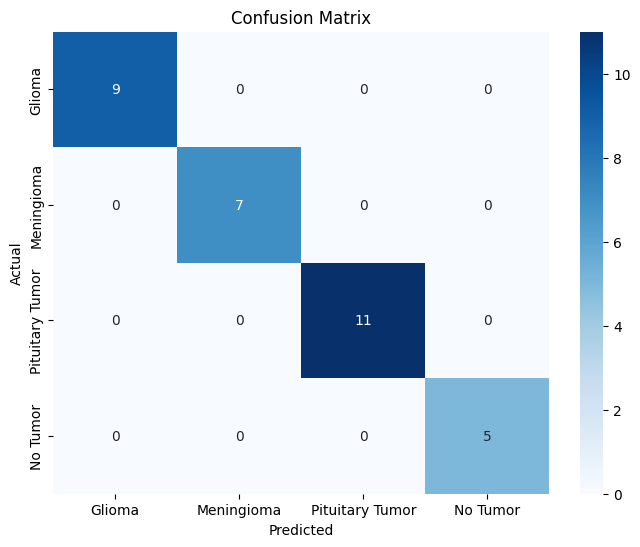

In [ ]:
test_images, test_labels = next(iter(testing_data_set))
predictions = hybrid_model.predict(test_images)
pred_labels = np.argmax(predictions, axis=1)

report = classification_report(test_labels, pred_labels, target_names=['Glioma', 'Meningioma', 'Pituitary Tumor', 'No Tumor'])
print(report)

conf_matrix = confusion_matrix(test_labels, pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Glioma', 'Meningioma', 'Pituitary Tumor', 'No Tumor'],
            yticklabels=['Glioma', 'Meningioma', 'Pituitary Tumor', 'No Tumor'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

4.3 Graphical Analysis of Performance

The following plots illustarte the training and validation metrics over epochs, focusing on recall, precision and accuracy.

4.3.1 Metrics Plotting Implementation

Plot training & validation accuracy and loss values

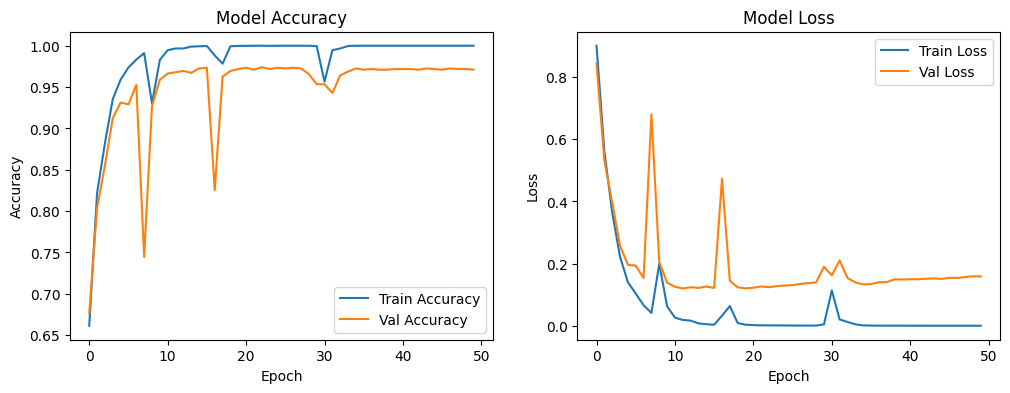

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

4.3.1 Metrics Plotting Implementation

Generate predictions on the entire validation dataset

Iterate over the test dataset to collect all predictions and labels

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       1.00      0.92      0.96        12
     Meningioma       0.88      1.00      0.93         7
Pituitary Tumor       1.00      1.00      1.00         6
       No Tumor       1.00      1.00      1.00         7

       accuracy                           0.97        32
      macro avg       0.97      0.98      0.97        32
   weighted avg       0.97      0.97      0.97        32

Overall Accuracy: 96.88%


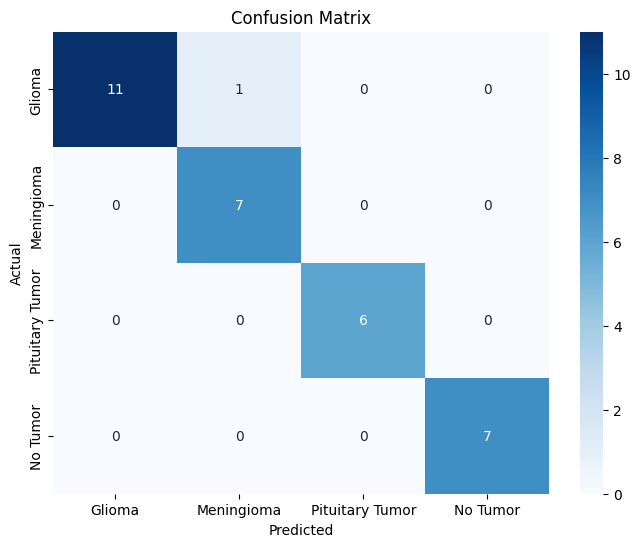

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       1.00      0.95      0.97        19
     Meningioma       0.94      1.00      0.97        15
Pituitary Tumor       1.00      1.00      1.00        14
       No Tumor       1.00      1.00      1.00        16

       accuracy                           0.98        64
      macro avg       0.98      0.99      0.99        64
   weighted avg       0.99      0.98      0.98        64

Overall Accuracy: 98.44%


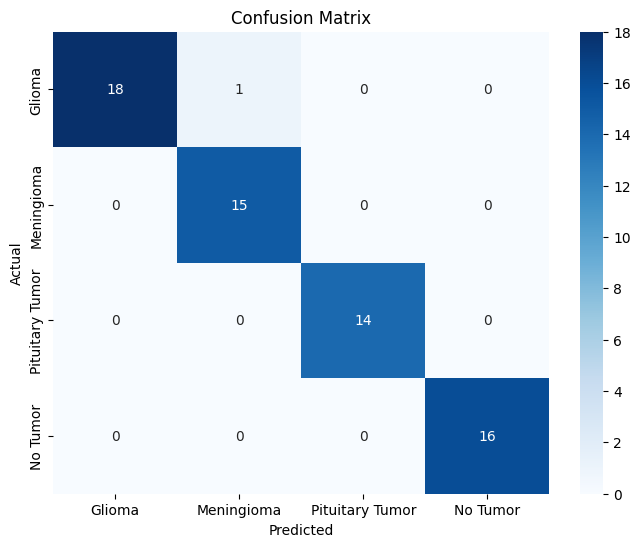

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       1.00      0.96      0.98        25
     Meningioma       0.96      0.96      0.96        23
Pituitary Tumor       1.00      1.00      1.00        23
       No Tumor       0.96      1.00      0.98        25

       accuracy                           0.98        96
      macro avg       0.98      0.98      0.98        96
   weighted avg       0.98      0.98      0.98        96

Overall Accuracy: 97.92%


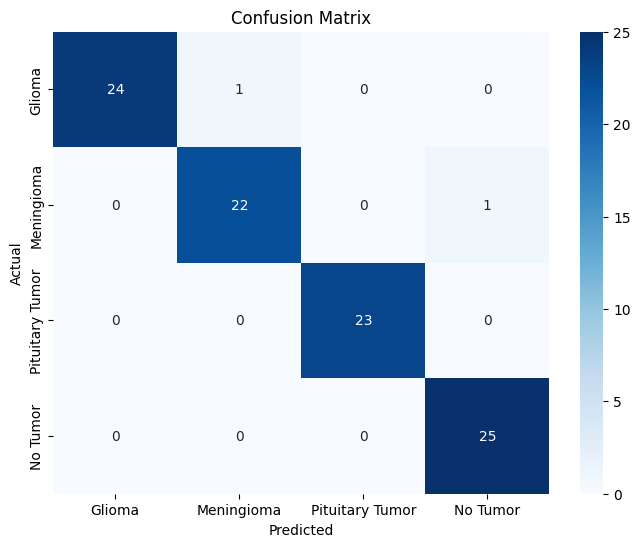

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       1.00      0.97      0.98        30
     Meningioma       0.97      0.97      0.97        30
Pituitary Tumor       1.00      1.00      1.00        33
       No Tumor       0.97      1.00      0.99        35

       accuracy                           0.98       128
      macro avg       0.98      0.98      0.98       128
   weighted avg       0.98      0.98      0.98       128

Overall Accuracy: 98.44%


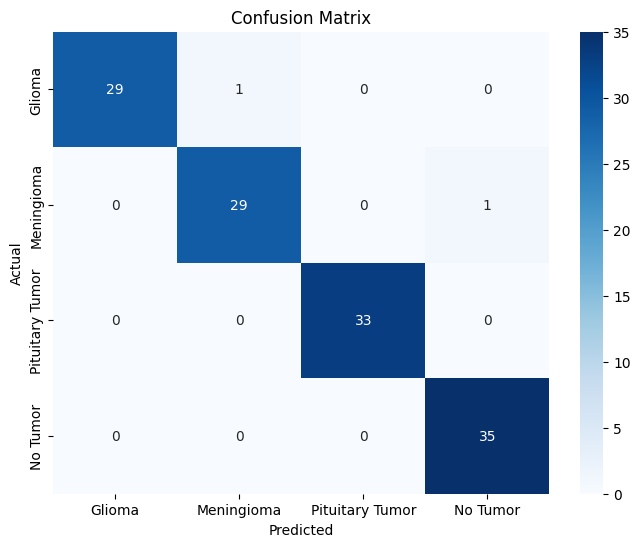

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       1.00      0.97      0.98        33
     Meningioma       0.97      0.97      0.97        35
Pituitary Tumor       1.00      1.00      1.00        51
       No Tumor       0.98      1.00      0.99        41

       accuracy                           0.99       160
      macro avg       0.99      0.99      0.99       160
   weighted avg       0.99      0.99      0.99       160

Overall Accuracy: 98.75%


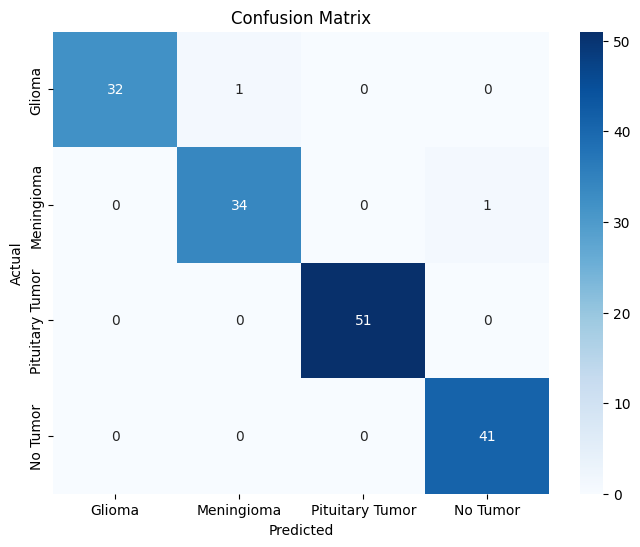

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       1.00      0.93      0.96        41
     Meningioma       0.93      0.98      0.96        44
Pituitary Tumor       1.00      1.00      1.00        58
       No Tumor       0.98      1.00      0.99        49

       accuracy                           0.98       192
      macro avg       0.98      0.98      0.98       192
   weighted avg       0.98      0.98      0.98       192

Overall Accuracy: 97.92%


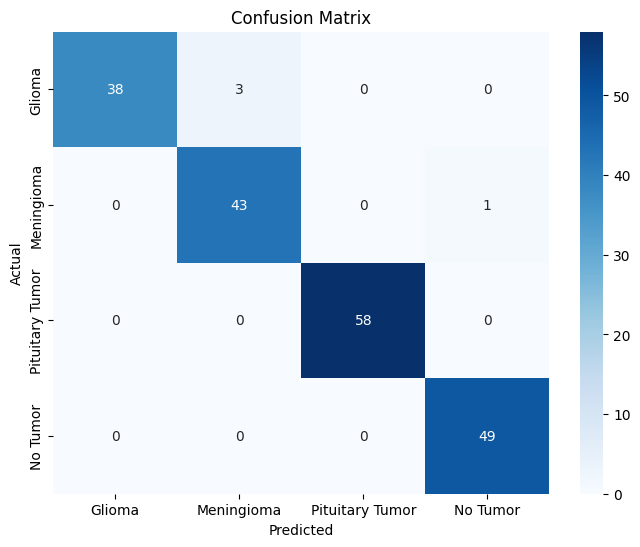

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       1.00      0.94      0.97        50
     Meningioma       0.94      0.98      0.96        48
Pituitary Tumor       1.00      1.00      1.00        70
       No Tumor       0.98      1.00      0.99        56

       accuracy                           0.98       224
      macro avg       0.98      0.98      0.98       224
   weighted avg       0.98      0.98      0.98       224

Overall Accuracy: 98.21%


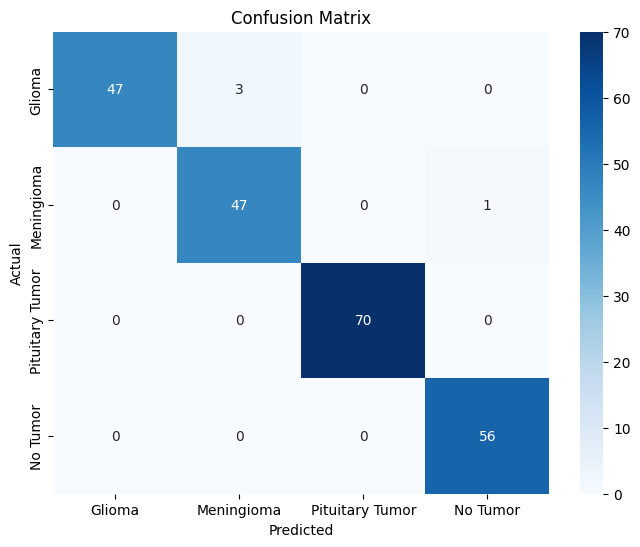

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.98      0.95      0.97        59
     Meningioma       0.94      0.96      0.95        53
Pituitary Tumor       1.00      1.00      1.00        82
       No Tumor       0.98      1.00      0.99        62

       accuracy                           0.98       256
      macro avg       0.98      0.98      0.98       256
   weighted avg       0.98      0.98      0.98       256

Overall Accuracy: 98.05%


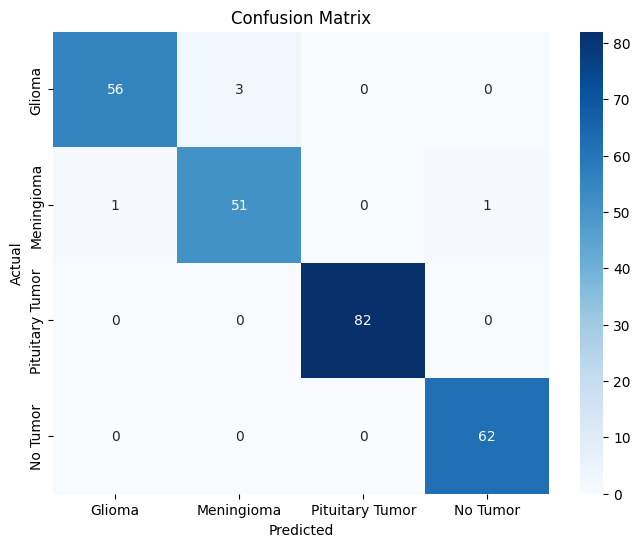

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.97      0.96      0.96        67
     Meningioma       0.95      0.95      0.95        61
Pituitary Tumor       1.00      1.00      1.00        94
       No Tumor       0.99      1.00      0.99        66

       accuracy                           0.98       288
      macro avg       0.98      0.98      0.98       288
   weighted avg       0.98      0.98      0.98       288

Overall Accuracy: 97.92%


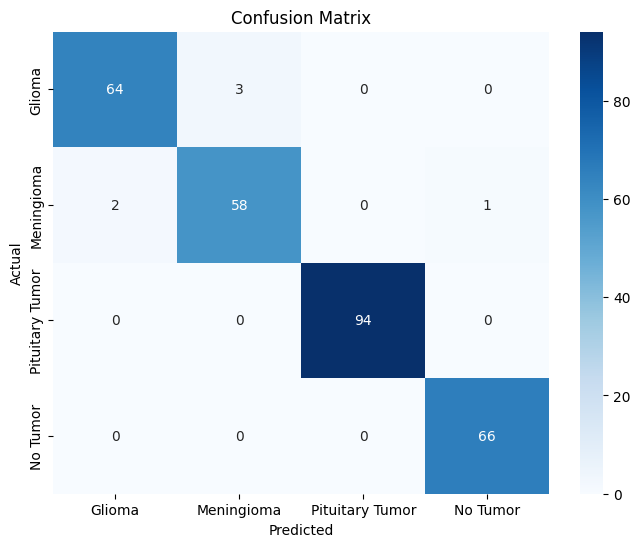

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.97      0.96      0.96        69
     Meningioma       0.96      0.96      0.96        71
Pituitary Tumor       1.00      1.00      1.00       108
       No Tumor       0.99      1.00      0.99        72

       accuracy                           0.98       320
      macro avg       0.98      0.98      0.98       320
   weighted avg       0.98      0.98      0.98       320

Overall Accuracy: 98.12%


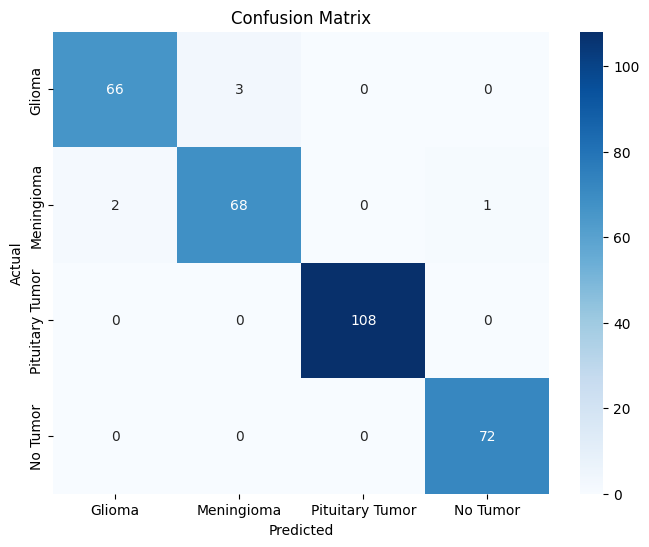

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.97      0.95      0.96        79
     Meningioma       0.95      0.96      0.95        77
Pituitary Tumor       1.00      1.00      1.00       118
       No Tumor       0.99      1.00      0.99        78

       accuracy                           0.98       352
      macro avg       0.98      0.98      0.98       352
   weighted avg       0.98      0.98      0.98       352

Overall Accuracy: 98.01%


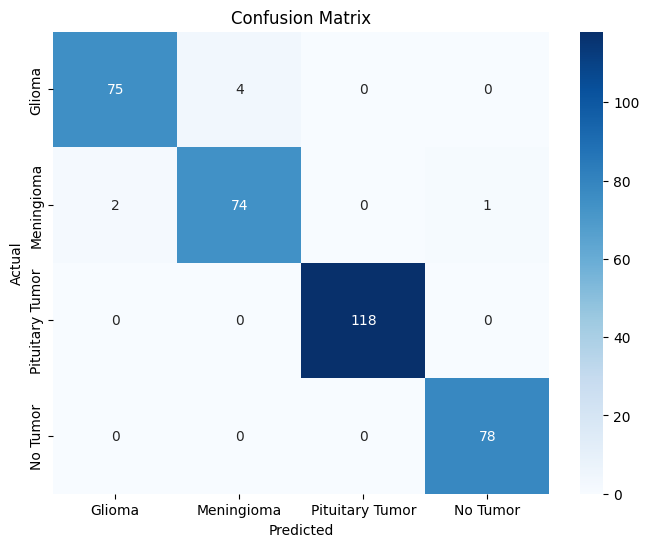

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.97      0.94      0.96        83
     Meningioma       0.94      0.96      0.95        85
Pituitary Tumor       1.00      1.00      1.00       128
       No Tumor       0.99      1.00      0.99        88

       accuracy                           0.98       384
      macro avg       0.98      0.98      0.98       384
   weighted avg       0.98      0.98      0.98       384

Overall Accuracy: 97.92%


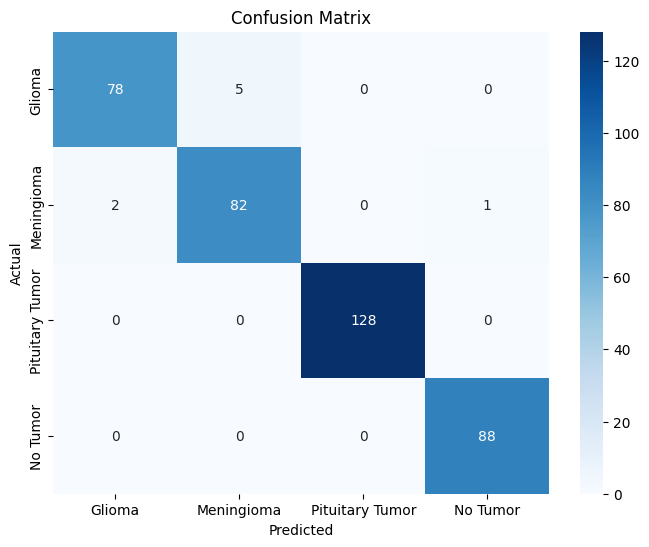

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.98      0.94      0.96        85
     Meningioma       0.95      0.96      0.95        90
Pituitary Tumor       1.00      1.00      1.00       145
       No Tumor       0.98      1.00      0.99        96

       accuracy                           0.98       416
      macro avg       0.98      0.97      0.97       416
   weighted avg       0.98      0.98      0.98       416

Overall Accuracy: 97.84%


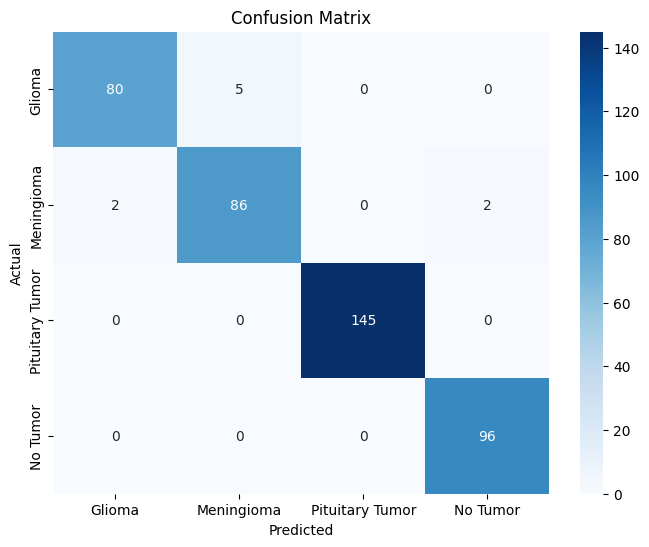

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.98      0.95      0.96        93
     Meningioma       0.95      0.96      0.96       104
Pituitary Tumor       1.00      1.00      1.00       153
       No Tumor       0.98      1.00      0.99        98

       accuracy                           0.98       448
      macro avg       0.98      0.98      0.98       448
   weighted avg       0.98      0.98      0.98       448

Overall Accuracy: 97.99%


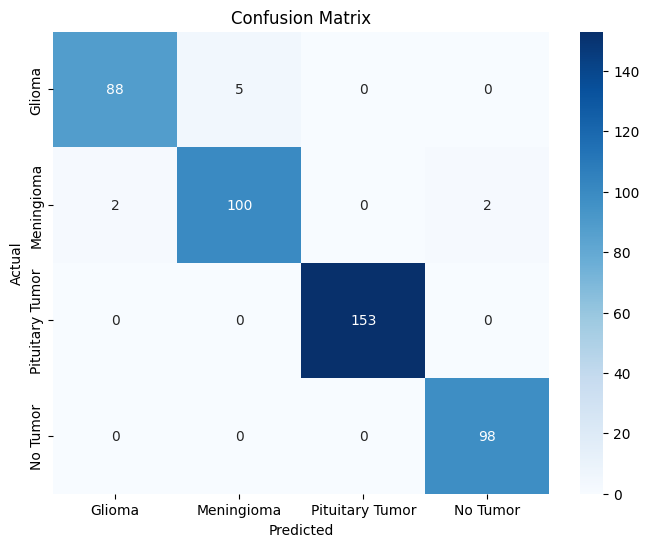

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.97      0.95      0.96       102
     Meningioma       0.95      0.95      0.95       111
Pituitary Tumor       1.00      1.00      1.00       163
       No Tumor       0.98      1.00      0.99       104

       accuracy                           0.98       480
      macro avg       0.98      0.98      0.98       480
   weighted avg       0.98      0.98      0.98       480

Overall Accuracy: 97.92%


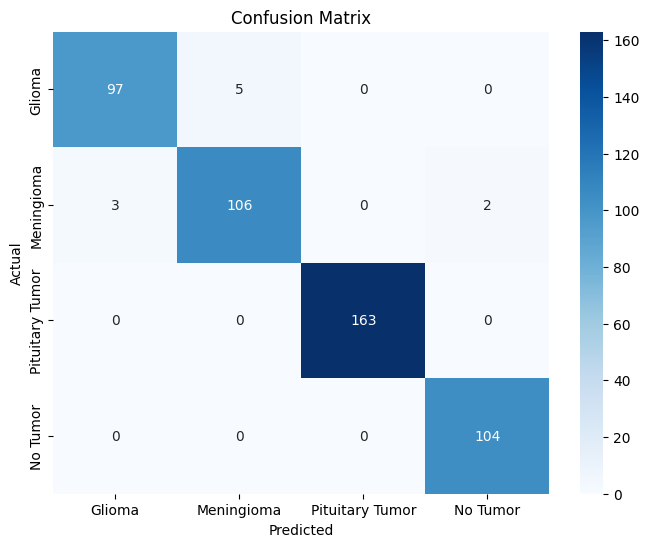

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.96      0.94      0.95       106
     Meningioma       0.95      0.95      0.95       121
Pituitary Tumor       1.00      1.00      1.00       175
       No Tumor       0.98      1.00      0.99       110

       accuracy                           0.98       512
      macro avg       0.97      0.97      0.97       512
   weighted avg       0.98      0.98      0.98       512

Overall Accuracy: 97.66%


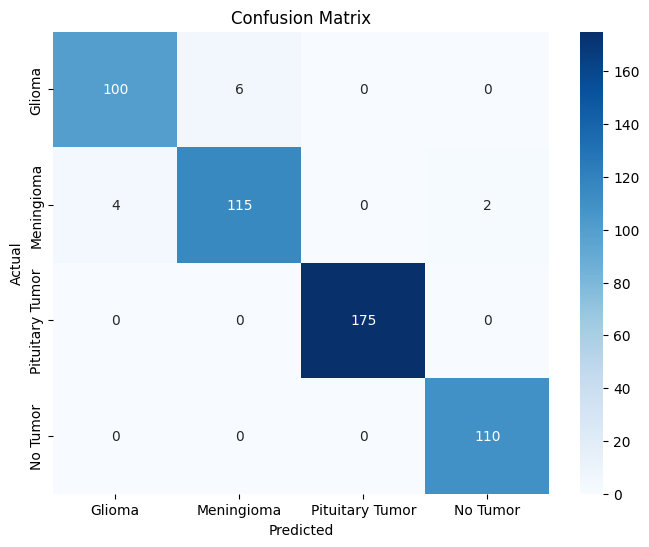

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.96      0.95      0.96       114
     Meningioma       0.95      0.95      0.95       128
Pituitary Tumor       1.00      1.00      1.00       184
       No Tumor       0.98      1.00      0.99       118

       accuracy                           0.98       544
      macro avg       0.98      0.98      0.98       544
   weighted avg       0.98      0.98      0.98       544

Overall Accuracy: 97.79%


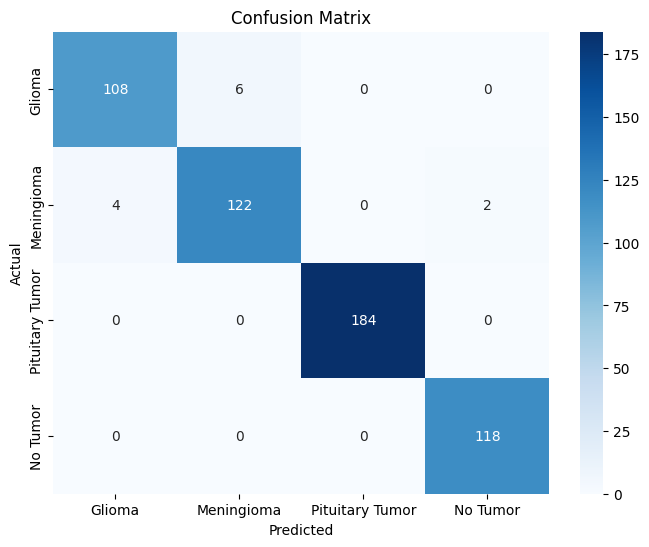

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.96      0.95      0.96       124
     Meningioma       0.96      0.95      0.95       137
Pituitary Tumor       1.00      1.00      1.00       192
       No Tumor       0.98      1.00      0.99       123

       accuracy                           0.98       576
      macro avg       0.97      0.98      0.97       576
   weighted avg       0.98      0.98      0.98       576

Overall Accuracy: 97.74%


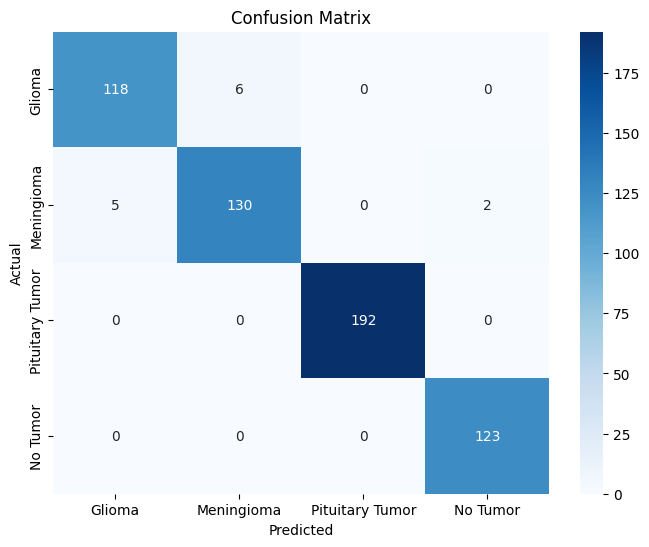

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.96      0.95      0.95       133
     Meningioma       0.95      0.94      0.94       144
Pituitary Tumor       1.00      1.00      1.00       202
       No Tumor       0.97      1.00      0.98       129

       accuracy                           0.97       608
      macro avg       0.97      0.97      0.97       608
   weighted avg       0.97      0.97      0.97       608

Overall Accuracy: 97.37%


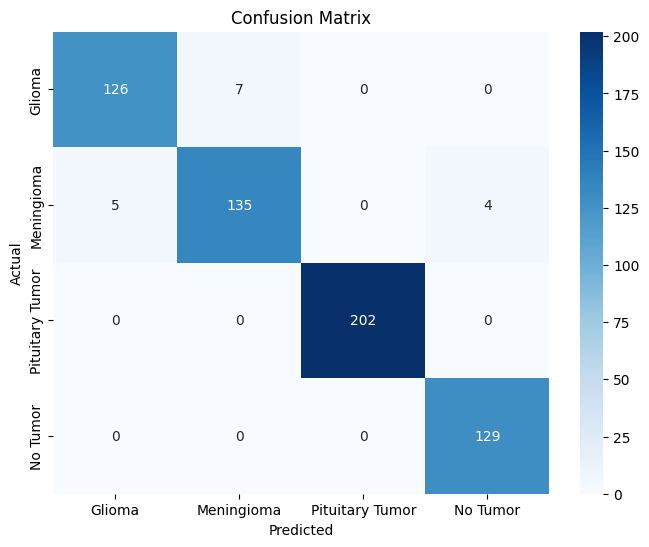

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.96      0.94      0.95       141
     Meningioma       0.95      0.94      0.94       151
Pituitary Tumor       1.00      1.00      1.00       217
       No Tumor       0.97      1.00      0.98       131

       accuracy                           0.97       640
      macro avg       0.97      0.97      0.97       640
   weighted avg       0.97      0.97      0.97       640

Overall Accuracy: 97.34%


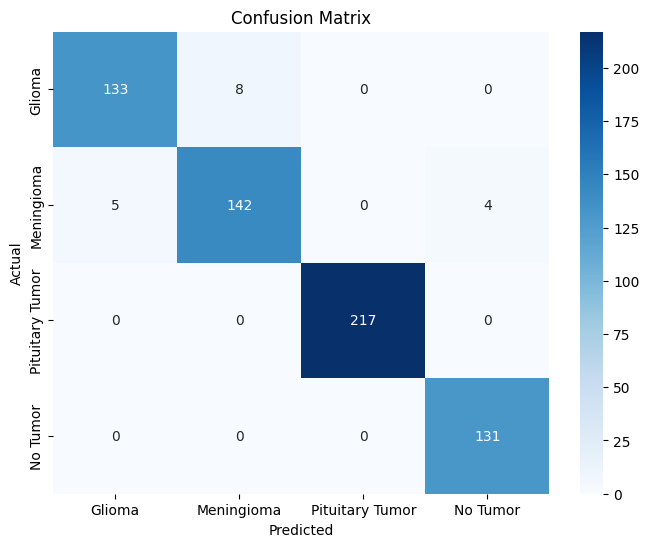

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.96      0.94      0.95       145
     Meningioma       0.95      0.94      0.94       158
Pituitary Tumor       1.00      1.00      1.00       229
       No Tumor       0.97      1.00      0.99       140

       accuracy                           0.97       672
      macro avg       0.97      0.97      0.97       672
   weighted avg       0.97      0.97      0.97       672

Overall Accuracy: 97.32%


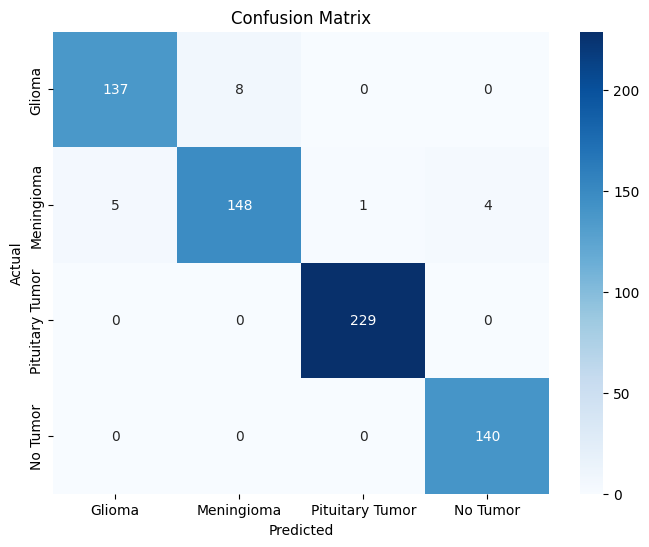

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.97      0.94      0.95       157
     Meningioma       0.95      0.94      0.95       166
Pituitary Tumor       1.00      1.00      1.00       234
       No Tumor       0.97      1.00      0.98       147

       accuracy                           0.97       704
      macro avg       0.97      0.97      0.97       704
   weighted avg       0.97      0.97      0.97       704

Overall Accuracy: 97.30%


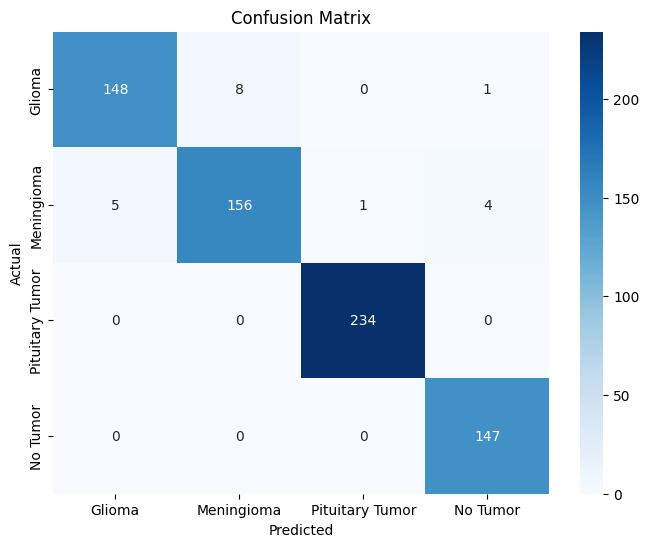

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.97      0.95      0.96       167
     Meningioma       0.95      0.94      0.95       171
Pituitary Tumor       1.00      1.00      1.00       243
       No Tumor       0.97      1.00      0.98       155

       accuracy                           0.97       736
      macro avg       0.97      0.97      0.97       736
   weighted avg       0.97      0.97      0.97       736

Overall Accuracy: 97.42%


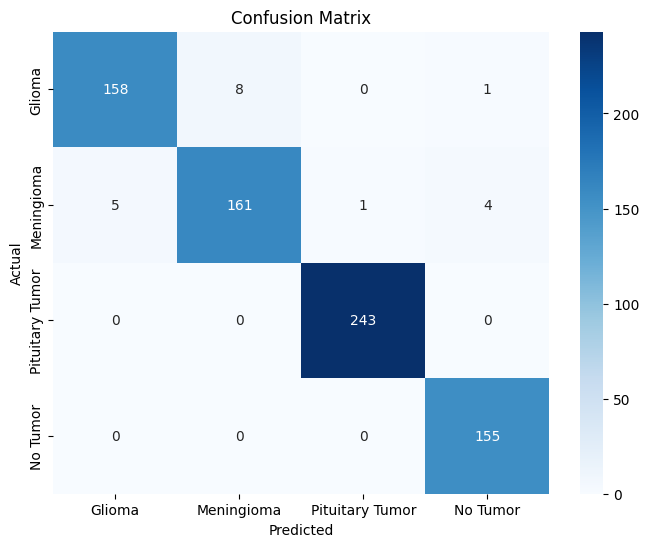

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.97      0.94      0.96       178
     Meningioma       0.95      0.94      0.94       173
Pituitary Tumor       1.00      1.00      1.00       258
       No Tumor       0.97      1.00      0.98       159

       accuracy                           0.97       768
      macro avg       0.97      0.97      0.97       768
   weighted avg       0.97      0.97      0.97       768

Overall Accuracy: 97.40%


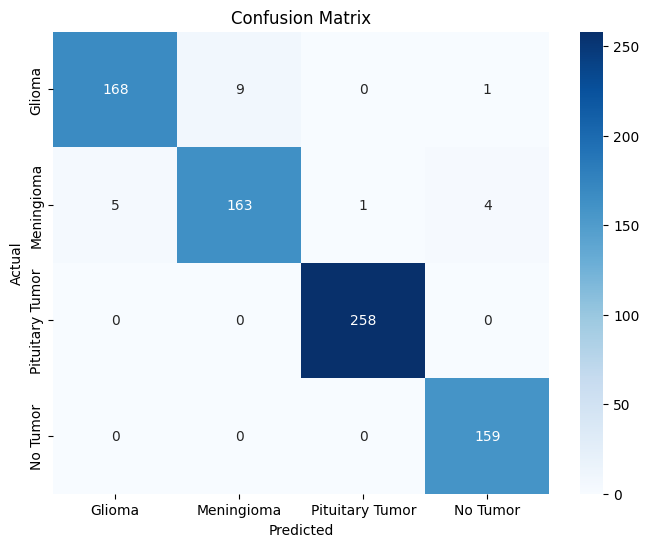

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.96      0.94      0.95       188
     Meningioma       0.94      0.92      0.93       183
Pituitary Tumor       0.99      1.00      1.00       263
       No Tumor       0.97      1.00      0.99       166

       accuracy                           0.97       800
      macro avg       0.97      0.97      0.97       800
   weighted avg       0.97      0.97      0.97       800

Overall Accuracy: 96.88%


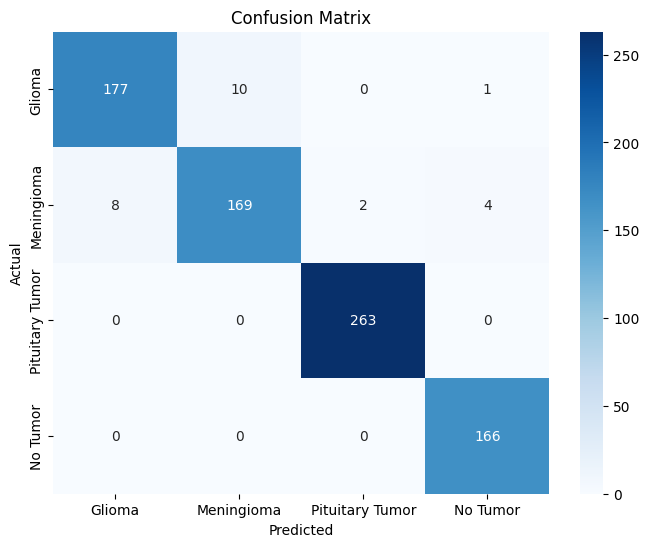

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.96      0.94      0.95       193
     Meningioma       0.95      0.93      0.94       190
Pituitary Tumor       0.99      1.00      1.00       271
       No Tumor       0.97      1.00      0.99       178

       accuracy                           0.97       832
      macro avg       0.97      0.97      0.97       832
   weighted avg       0.97      0.97      0.97       832

Overall Accuracy: 97.00%


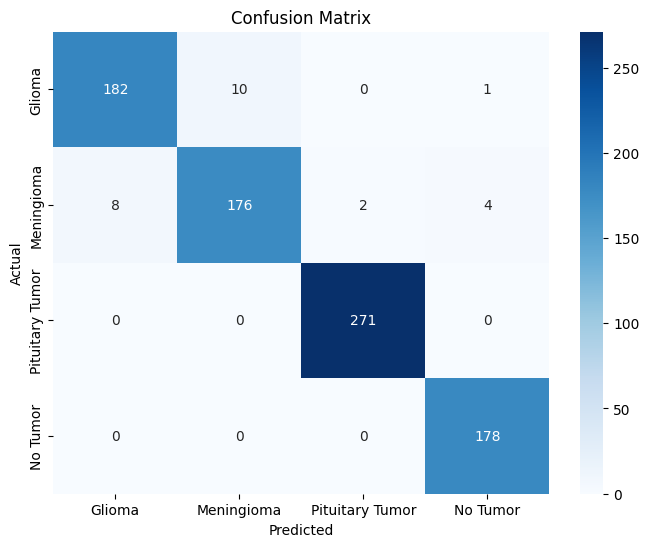

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.96      0.94      0.95       203
     Meningioma       0.94      0.93      0.94       195
Pituitary Tumor       0.99      1.00      1.00       280
       No Tumor       0.97      1.00      0.99       186

       accuracy                           0.97       864
      macro avg       0.97      0.97      0.97       864
   weighted avg       0.97      0.97      0.97       864

Overall Accuracy: 96.99%


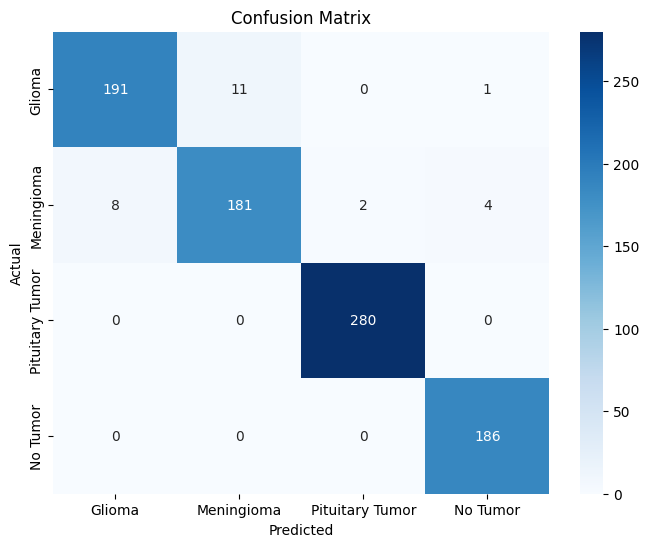

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.96      0.94      0.95       210
     Meningioma       0.94      0.93      0.94       203
Pituitary Tumor       0.99      1.00      1.00       292
       No Tumor       0.97      1.00      0.99       191

       accuracy                           0.97       896
      macro avg       0.97      0.97      0.97       896
   weighted avg       0.97      0.97      0.97       896

Overall Accuracy: 97.10%


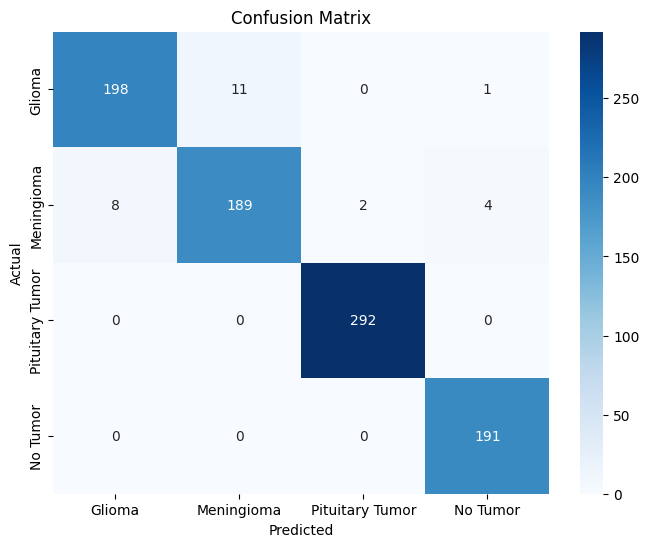

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.96      0.93      0.95       223
     Meningioma       0.94      0.93      0.94       209
Pituitary Tumor       0.99      1.00      1.00       298
       No Tumor       0.97      1.00      0.99       198

       accuracy                           0.97       928
      macro avg       0.97      0.97      0.97       928
   weighted avg       0.97      0.97      0.97       928

Overall Accuracy: 96.88%


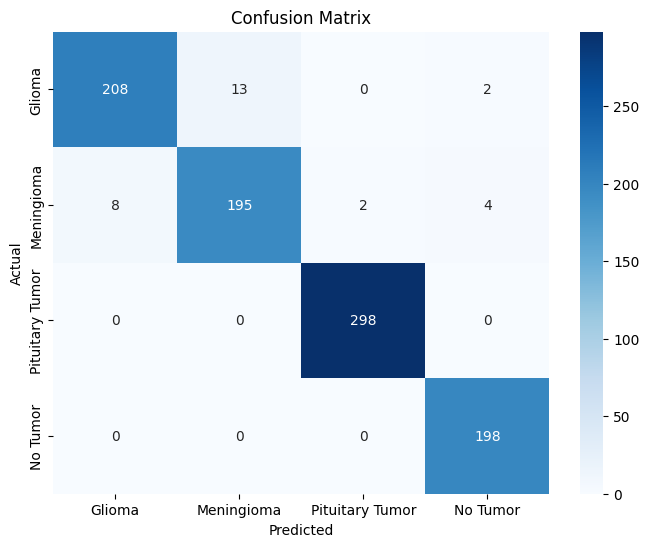

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.96      0.93      0.95       230
     Meningioma       0.94      0.94      0.94       218
Pituitary Tumor       0.99      1.00      1.00       307
       No Tumor       0.97      1.00      0.99       205

       accuracy                           0.97       960
      macro avg       0.97      0.97      0.97       960
   weighted avg       0.97      0.97      0.97       960

Overall Accuracy: 96.98%


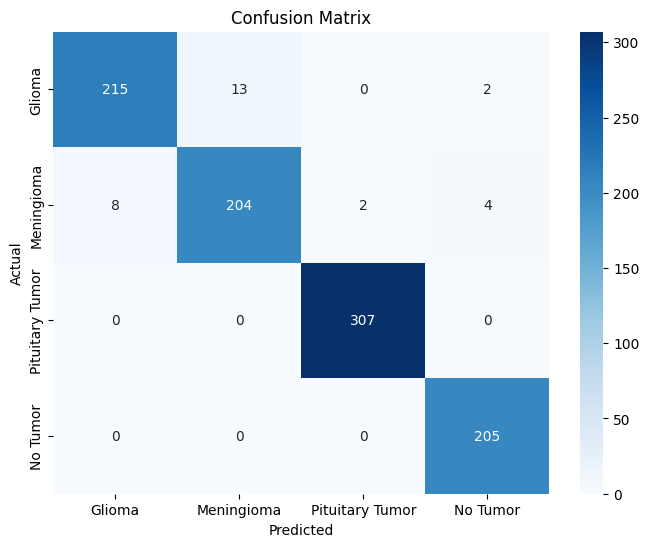

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.96      0.94      0.95       232
     Meningioma       0.94      0.94      0.94       223
Pituitary Tumor       0.99      1.00      1.00       321
       No Tumor       0.97      1.00      0.99       216

       accuracy                           0.97       992
      macro avg       0.97      0.97      0.97       992
   weighted avg       0.97      0.97      0.97       992

Overall Accuracy: 97.08%


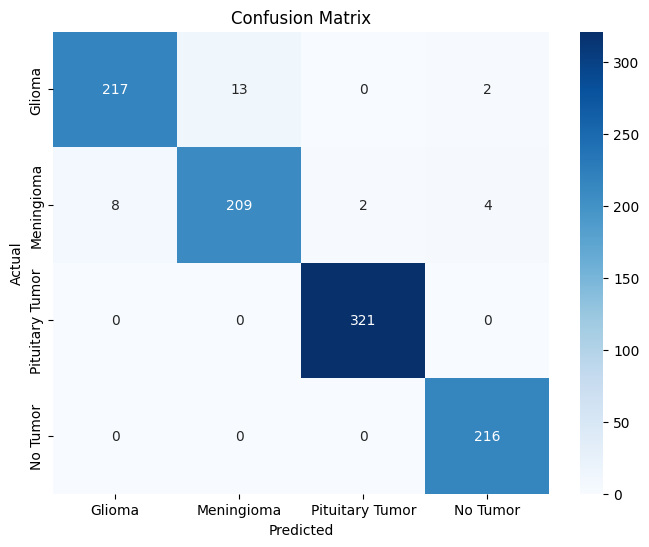

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.97      0.94      0.95       238
     Meningioma       0.94      0.94      0.94       231
Pituitary Tumor       0.99      1.00      1.00       326
       No Tumor       0.97      1.00      0.98       229

       accuracy                           0.97      1024
      macro avg       0.97      0.97      0.97      1024
   weighted avg       0.97      0.97      0.97      1024

Overall Accuracy: 97.07%


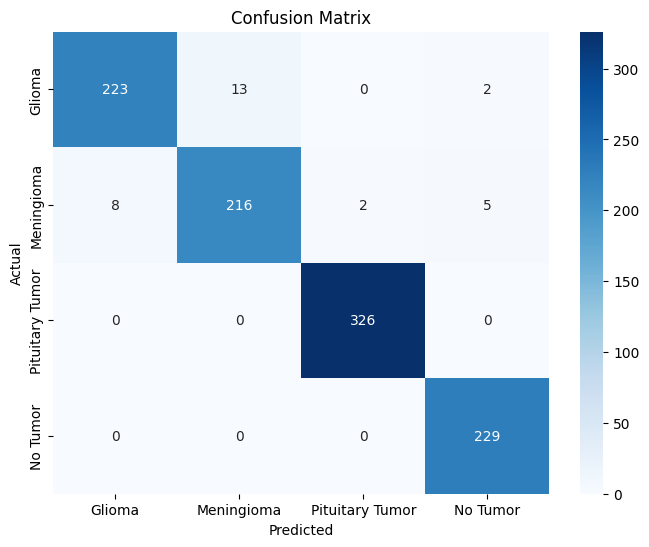

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.96      0.94      0.95       243
     Meningioma       0.95      0.93      0.94       240
Pituitary Tumor       0.99      1.00      1.00       334
       No Tumor       0.97      1.00      0.99       239

       accuracy                           0.97      1056
      macro avg       0.97      0.97      0.97      1056
   weighted avg       0.97      0.97      0.97      1056

Overall Accuracy: 97.06%


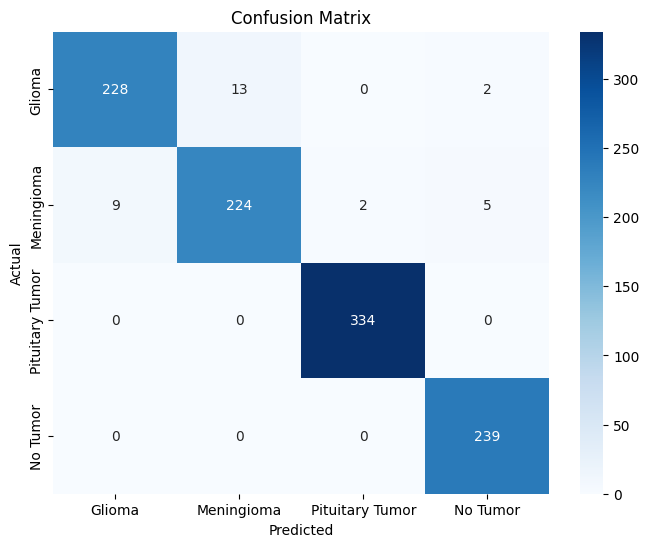

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.96      0.94      0.95       252
     Meningioma       0.95      0.93      0.94       250
Pituitary Tumor       0.99      1.00      1.00       339
       No Tumor       0.97      1.00      0.98       247

       accuracy                           0.97      1088
      macro avg       0.97      0.97      0.97      1088
   weighted avg       0.97      0.97      0.97      1088

Overall Accuracy: 96.97%


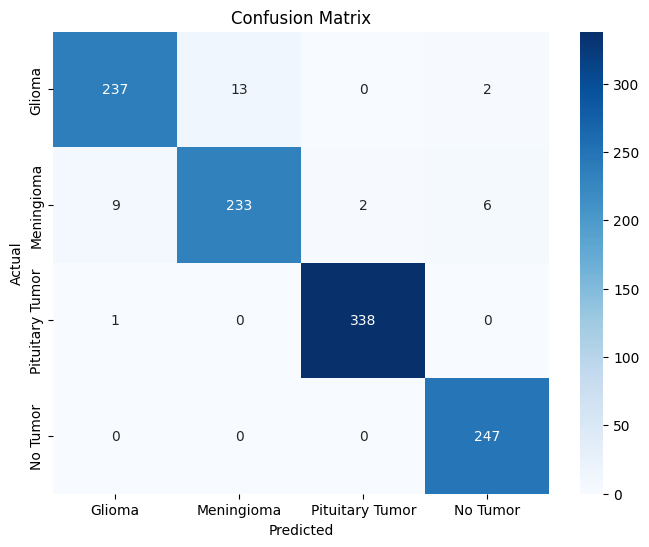

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.96      0.94      0.95       253
     Meningioma       0.95      0.93      0.94       255
Pituitary Tumor       0.99      1.00      1.00       351
       No Tumor       0.97      1.00      0.98       261

       accuracy                           0.97      1120
      macro avg       0.97      0.97      0.97      1120
   weighted avg       0.97      0.97      0.97      1120

Overall Accuracy: 96.96%


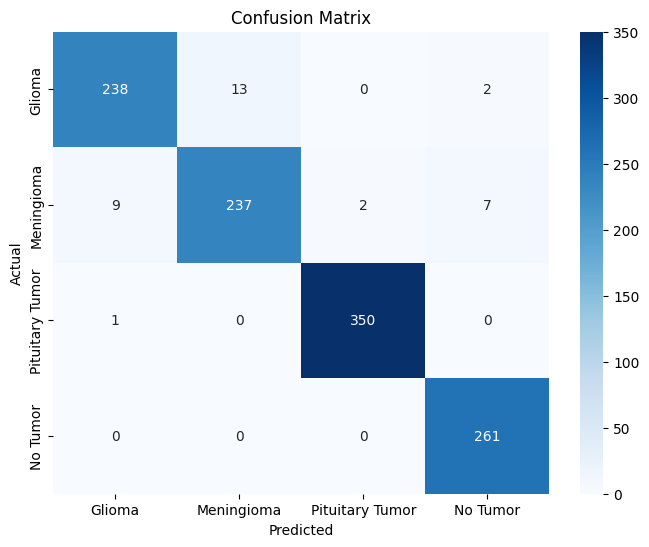

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.96      0.94      0.95       261
     Meningioma       0.95      0.93      0.94       263
Pituitary Tumor       0.99      1.00      1.00       357
       No Tumor       0.97      1.00      0.98       271

       accuracy                           0.97      1152
      macro avg       0.97      0.97      0.97      1152
   weighted avg       0.97      0.97      0.97      1152

Overall Accuracy: 96.96%


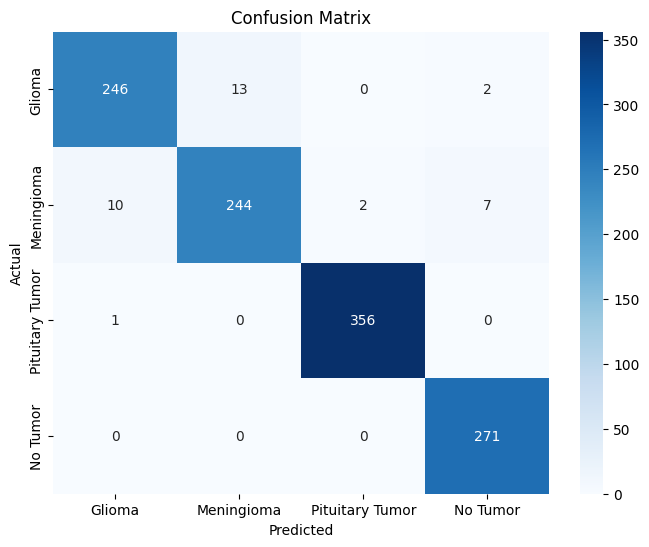

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.96      0.94      0.95       269
     Meningioma       0.95      0.93      0.94       272
Pituitary Tumor       0.99      1.00      1.00       364
       No Tumor       0.97      1.00      0.98       279

       accuracy                           0.97      1184
      macro avg       0.97      0.97      0.97      1184
   weighted avg       0.97      0.97      0.97      1184

Overall Accuracy: 97.04%


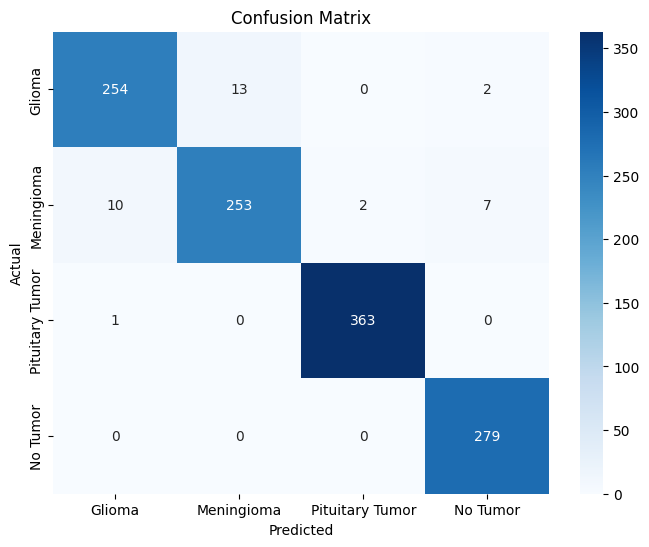

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.96      0.94      0.95       278
     Meningioma       0.95      0.93      0.94       278
Pituitary Tumor       0.99      1.00      1.00       374
       No Tumor       0.97      1.00      0.98       286

       accuracy                           0.97      1216
      macro avg       0.97      0.97      0.97      1216
   weighted avg       0.97      0.97      0.97      1216

Overall Accuracy: 96.96%


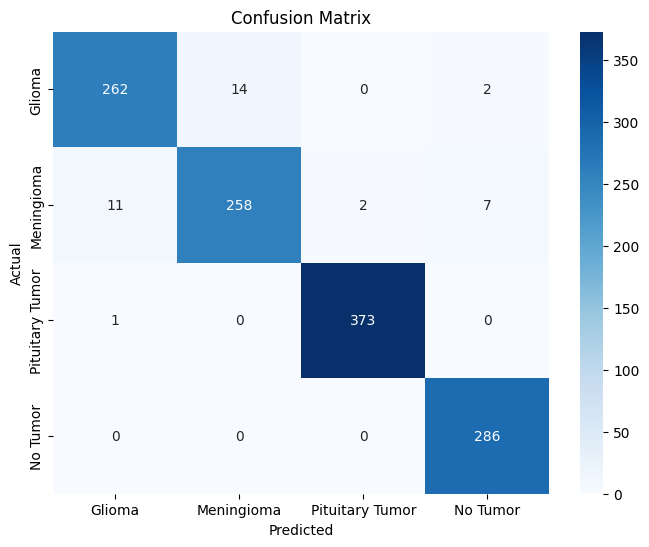

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.96      0.94      0.95       287
     Meningioma       0.95      0.93      0.94       289
Pituitary Tumor       0.99      1.00      1.00       381
       No Tumor       0.97      1.00      0.98       291

       accuracy                           0.97      1248
      macro avg       0.97      0.97      0.97      1248
   weighted avg       0.97      0.97      0.97      1248

Overall Accuracy: 97.04%


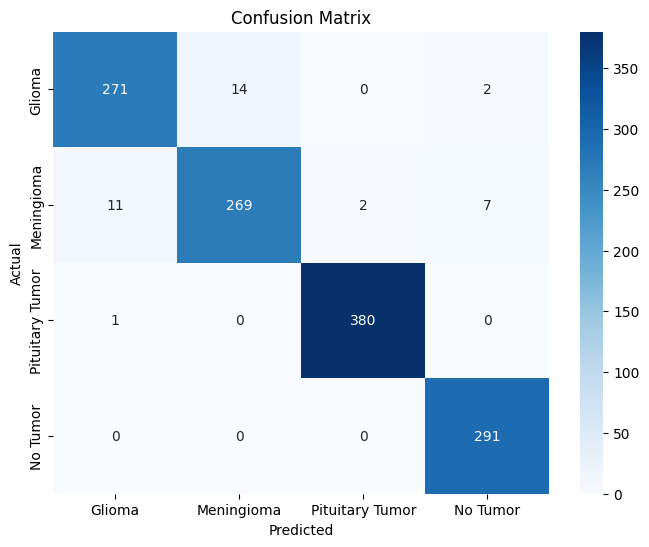

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.96      0.95      0.95       295
     Meningioma       0.95      0.93      0.94       296
Pituitary Tumor       0.99      1.00      1.00       395
       No Tumor       0.97      1.00      0.98       294

       accuracy                           0.97      1280
      macro avg       0.97      0.97      0.97      1280
   weighted avg       0.97      0.97      0.97      1280

Overall Accuracy: 97.11%


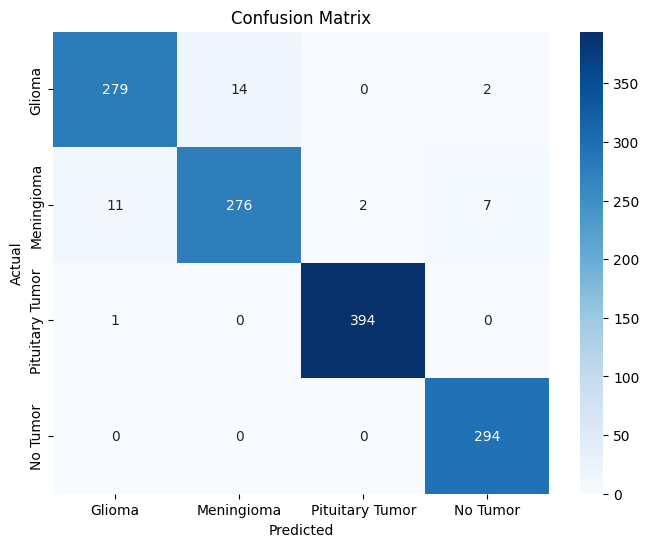

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.96      0.94      0.95       300
     Meningioma       0.95      0.93      0.94       306
Pituitary Tumor       1.00      1.00      1.00       405
       No Tumor       0.97      1.00      0.99       300

       accuracy                           0.97      1311
      macro avg       0.97      0.97      0.97      1311
   weighted avg       0.97      0.97      0.97      1311

Overall Accuracy: 97.10%


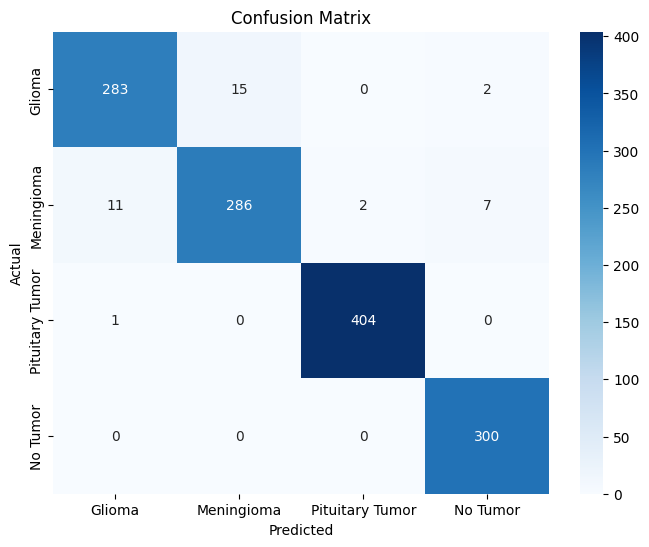

In [ ]:
all_predictions = []
all_labels = []

for images, labels in testing_data_set:
  predictions = hybrid_model.predict(images)
  pred_labels = np.argmax(predictions, axis=1)

  all_predictions.extend(pred_labels)
  all_labels.extend(labels.numpy())


  class_labels = ['Glioma', 'Meningioma', 'Pituitary Tumor', 'No Tumor']
  report = classification_report(all_labels, all_predictions, target_names=class_labels)
  print("Classification Report:")
  print(report)

  accuracy = accuracy_score(all_labels, all_predictions)
  print(f"Overall Accuracy: {accuracy * 100:.2f}%")

  conf_matrix = confusion_matrix(all_labels, all_predictions)
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
              xticklabels=class_labels,
              yticklabels=class_labels)
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

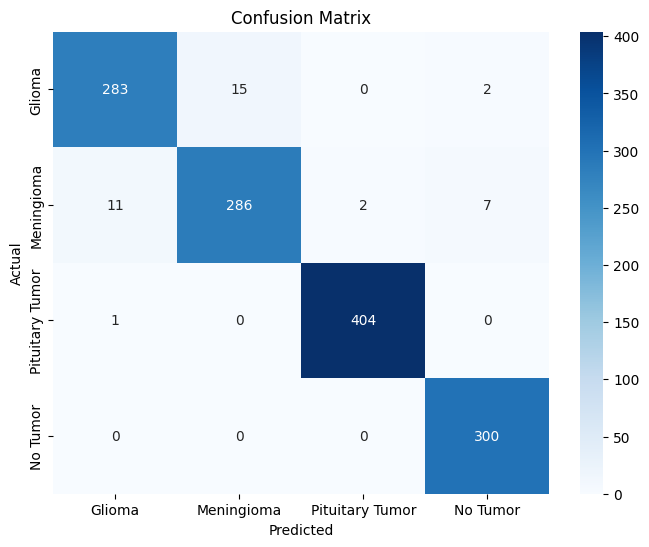

In [ ]:
# Generate predictions on the entire validation dataset
all_predictions = []
all_labels = []

# Iterate over the test dataset to collect all predictions and labels
for images, labels in testing_data_set:
    predictions = hybrid_model.predict(images)
    pred_labels = np.argmax(predictions, axis=1)

    all_predictions.extend(pred_labels)
    all_labels.extend(labels.numpy())

# Classification Report
class_labels = ['Glioma', 'Meningioma', 'Pituitary Tumor', 'No Tumor']
report = classification_report(all_labels, all_predictions, target_names=class_labels)
print("Classification Report:")
print(report)

# Calculate and print overall accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Recall (Sensitivity): Measures the ability of the model to identify positive cases. It’s the ratio of true positives to the sum of true positives and false negatives.

Precision: Measures the accuracy of positive predictions. It’s the ratio of true positives to the sum of true positives and false positives.

F1-Score: A weighted average of precision and recall. It’s useful for evaluating models where class imbalance exists.

Accuracy: Measures the proportion of correct predictions out of all predictions.

Training and Validation Accuracy Over Epochs
Shows how the model's accuracy evolves during training and validation.
Useful to detect overfitting or underfitting.

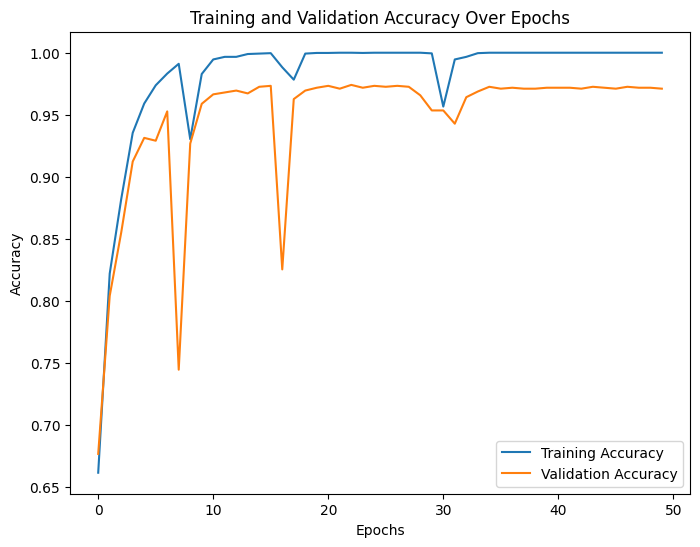

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

Training and Validation Loss Over Epochs
Displays how the loss decreases during training and validation.
Can help to identify if the training is stuck or not converging.

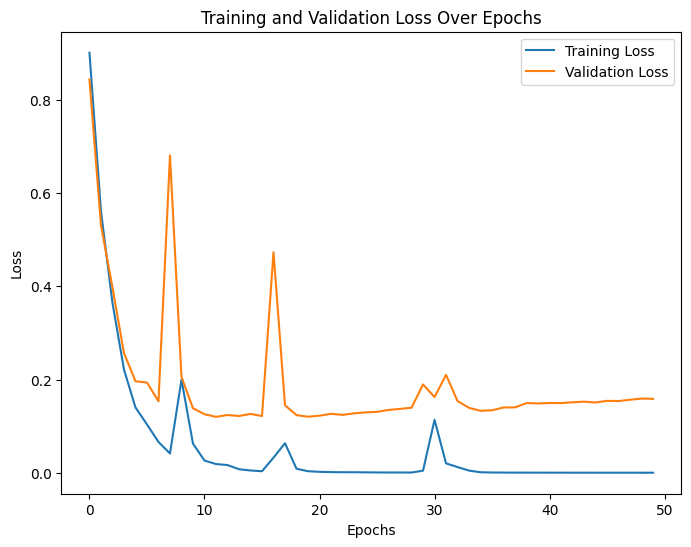

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

 Classification Summary Report

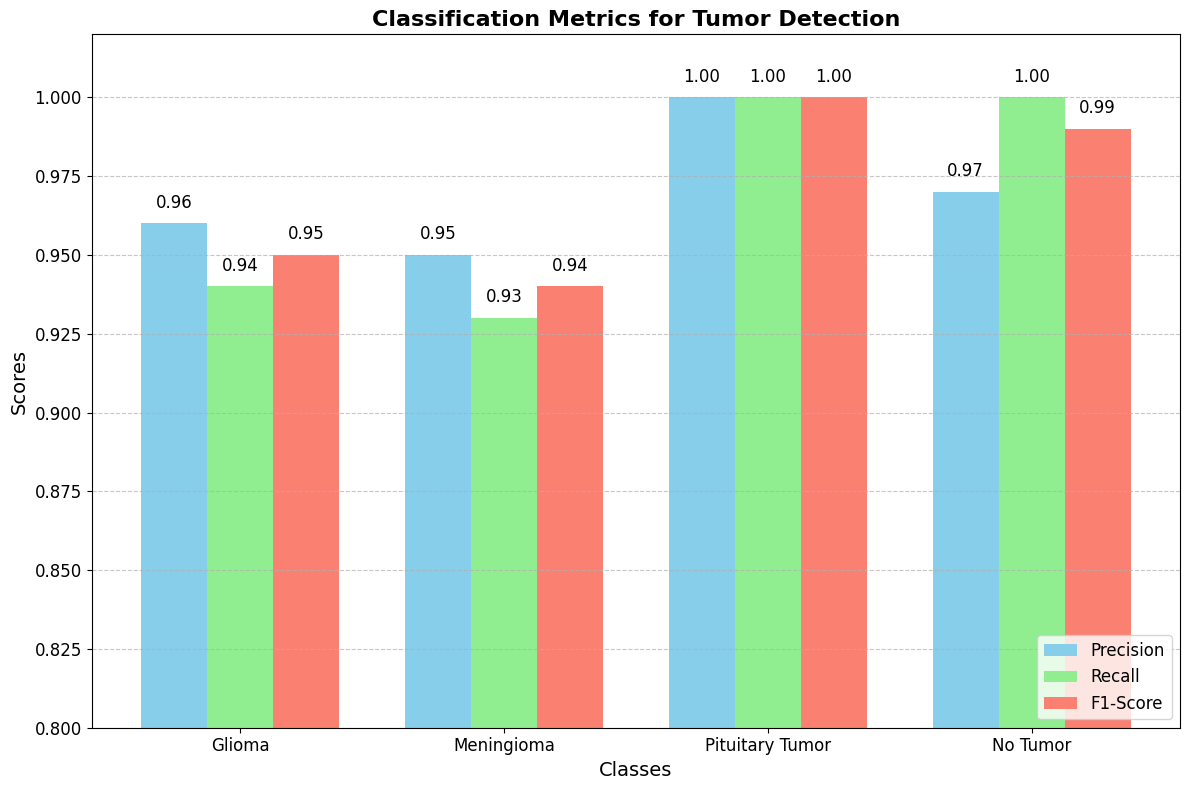

In [ ]:
classes = ["Glioma", "Meningioma", "Pituitary Tumor", "No Tumor" ]
precision = [0.96, 0.95, 1.00, 0.97]
recall = [0.94, 0.93, 1.00, 1.00]
f1_score = [0.95, 0.94, 1.00, 0.99]

x = np.arange(len(classes))

width = 0.25

plt.figure(figsize=(12, 8))

precision_bars = plt.bar(x - width, precision, width, label='Precision', color='skyblue')
recall_bars = plt.bar(x, recall, width, label='Recall', color='lightgreen')
f1_score_bars = plt.bar(x + width, f1_score, width, label='F1-Score', color='salmon')

for bars in [precision_bars, recall_bars, f1_score_bars]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.005, f'{yval:.2f}',
                 ha='center', fontsize=12, color='black')


plt.xlabel("Classes", fontsize=14)
plt.ylabel("Scores", fontsize=14)
plt.title("Classification Metrics for Tumor Detection", fontsize=16, fontweight='bold')
plt.xticks(x, classes, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0.8, 1.02)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend(fontsize=12, loc='lower right')

plt.tight_layout()
plt.show()


In [ ]:
# Predict on the test dataset
true_labels = []
predicted_labels = []

for images, labels in testing_data_set:
    predictions = hybrid_model.predict(images)
    predicted_classes = np.argmax(predictions, axis=-1)
    true_labels.extend(labels.numpy())
    predicted_labels.extend(predicted_classes)

# Generate classification report
print(classification_report(true_labels, predicted_labels, digits=4))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
y_pred = hybrid_model.predict(testing_data_set)
y_pred_classes = np.argmax(y_pred, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 375ms/step


41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 392ms/step
Precision: 0.36
Recall: 0.25
F1-Score: 0.12


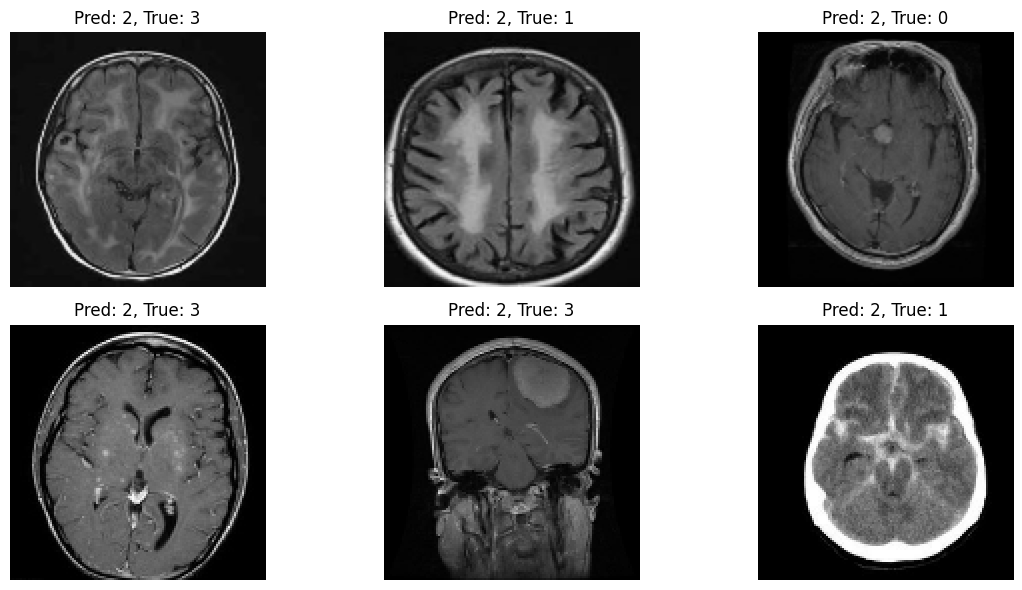

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.utils import to_categorical

# This shows how I Made predictions on the testing dataset
y_pred = hybrid_model.predict(testing_data_set)


# Here I Converted predicted probabilities to class labels

y_pred_classes = np.argmax(y_pred, axis=1)

# I now got true labels (one-hot encoded to integer labels)

y_true = np.concatenate([labels.numpy() for _, labels in testing_data_set], axis=0)
y_true_classes = np.argmax(y_true, axis=1)  # Convert one-hot encoded labels back to integer labels

# Calculate precision, recall, and F1-score using sklearn, handling undefined values
precision = precision_score(y_true_classes, y_pred_classes, average='macro', zero_division=1)
recall = recall_score(y_true_classes, y_pred_classes, average='macro', zero_division=1)
f1 = f1_score(y_true_classes, y_pred_classes, average='macro', zero_division=1)

# Output the results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Optional: Plot some of the predictions to verify visually
plt.figure(figsize=(12, 6))

# Displaying images from the batch and corresponding predictions took place from this step as shown below:
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i].numpy())  # Display the actual image, not the prediction vector
    plt.title(f"Pred: {y_pred_classes[i]}, True: {y_true_classes[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
precision = precision_score(y_true_classes, y_pred_classes, average='macro', zero_division=1)
recall = recall_score(y_true_classes, y_pred_classes, average='macro', zero_division=1)
f1 = f1_score(y_true_classes, y_pred_classes, average='macro', zero_division=1)

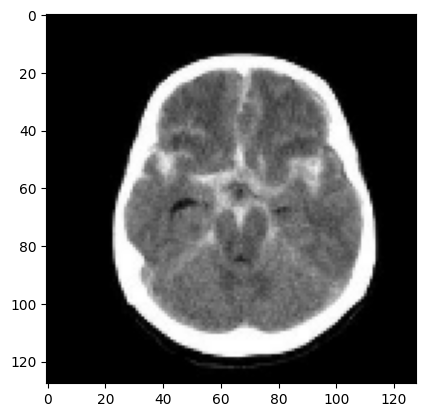

In [ ]:
plt.imshow(images[i].numpy())  # Display the actual image

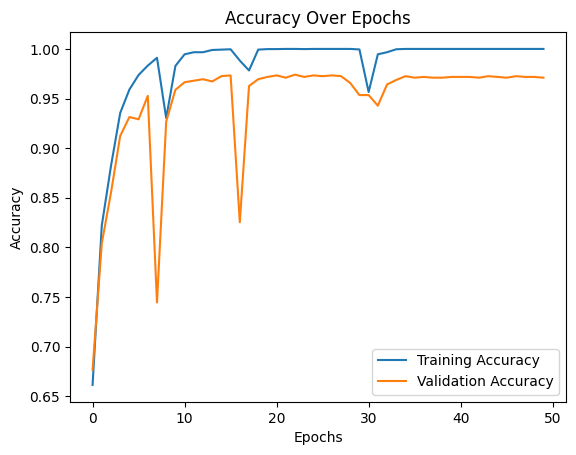

In [ ]:
# Example: Plot training and validation accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()


Extracting all validation data and comfirming the shapes

In [ ]:
x_val = np.concatenate([images.numpy() for images, _ in testing_data_set], axis=0)
y_val = np.concatenate([labels.numpy() for _, labels in testing_data_set], axis=0)

print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")


x_val shape: (1311, 128, 128, 3), y_val shape: (1311,)


Prediction Generation: The first step in evaluation is to generate predictions on the test dataset. This is done by passing the test dataset through the trained model. The model produces class probabilities for each image, which are then converted into class labels by taking the argmax along the appropriate axis (axis=1) to get the predicted class label for each image.

In [ ]:
y_pred = hybrid_model.predict(testing_data_set)
y_pred_classes = np.argmax(y_pred, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 24s 558ms/step


True Labels: The true labels (y_true) were extracted from the test dataset. Since the dataset uses integer labels rather than one-hot encoded labels, no further conversion is needed if the labels are already in integer form. However, if the labels were one-hot encoded, the np.argmax() function would have been used to convert them back to integer labels.

In [ ]:
y_true = np.concatenate([labels.numpy() for _, labels in testing_data_set], axis=0)
y_true_classes = np.argmax(y_true, axis=1)  # Convert one-hot encoded labels back to integer labels

In [ ]:
precision = precision_score(y_true_classes, y_pred_classes, average='macro', zero_division=1)
recall = recall_score(y_true_classes, y_pred_classes, average='macro', zero_division=1)
f1 = f1_score(y_true_classes, y_pred_classes, average='macro', zero_division=1)

The results for precision, recall, and F1-score were then printed, offering insights into the model’s performance across all classes:

 Image Display and Visualization of Predictions
Visualizing the predictions is another essential part of evaluating the model’s performance. This helps to understand whether the model is making correct predictions and which types of errors are being made. Here, I address an issue related to incorrectly attempting to display prediction vectors as images.

This allows for clear visualization of the model’s predictions and comparison with the true labels. By plotting images alongside their predicted and true labels, the performance of the model can be assessed more effectively, providing insights into areas where the model may be making consistent mistakes.

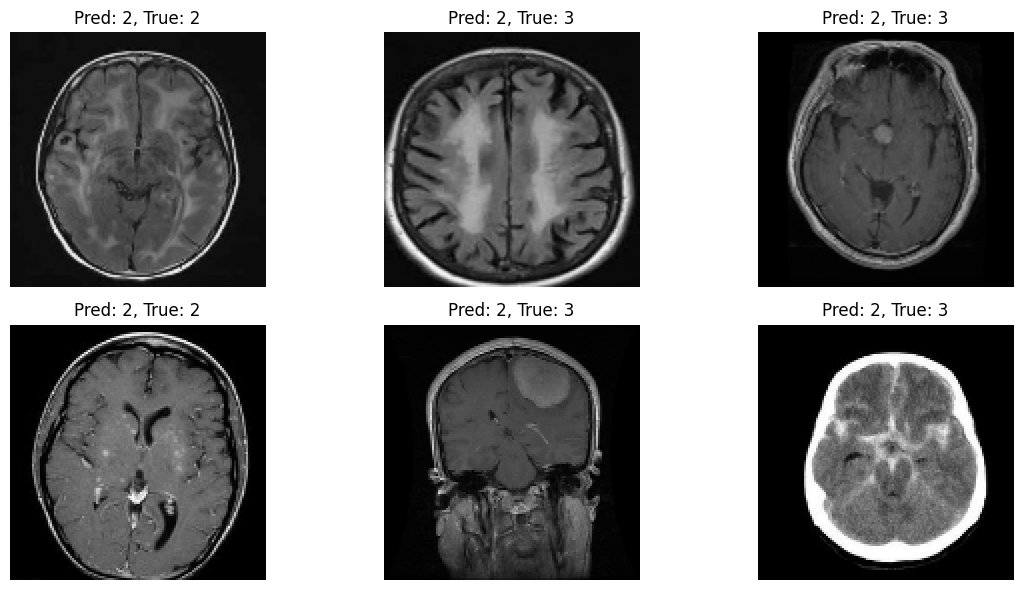

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i].numpy())
    plt.title(f"Pred: {y_pred_classes[i]}, True: {y_true_classes[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


5. Conclusion
This project showcases the successful implementation of a hybrid model integrating CNNs and Vision Transformers for brain tumor classification. The model effectively processes MRI images, achieving robust performance metrics. Future work could explore fine-tuning the model's hyperparameters, increasing dataset diversity, or leveraging transfer learning for improved accuracy.